In [2]:
import cv2
import log_reg
import numpy as np
from glob import glob
from matplotlib.pyplot import imread, imshow
from util import read_X_Y, get_data_col, filter_data_by_colval
from keras.models import Sequential 
from keras.layers import Dense, Activation, Reshape
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#TensorBoard
from keras.callbacks import TensorBoard, ModelCheckpoint
from time import time
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6764954679245149063
]


In [88]:
file_names = sorted(glob('all-mias/*.pgm'))
# print(file_names)

In [89]:
headers = ['file_name', 'character', 'class', 'severity', 'x', 'y', 'radius']
filtered_X, Y_headers,Y_names, Ben_Mag = read_X_Y('dataset/data.txt',headers)

In [90]:
print(len(filtered_X))

326


In [91]:
#Preprocessing is now being exmpanded to include NORM files and calcification data
def get_filtered_data(fname, sep=' '):
    # some calcified data have multiple tumors in image and the data comes with multiple centers and radii
    overlay_data = {} # col[0] --> [np.array(cols[4],cols[5],cols[6]), ]
    filtered_X_fnames = []
    filtered_base_fnames = []
    ben_mag_data = {} # B, M, -1 (for N/A)
    with open(fname) as f:
        for line in f:
            line = line.strip()
            cols = line.split(sep)

            if len(cols) == 7 and not cols[2] == 'NORM':
                filtered_X_fnames.append('all-mias/' + cols[0] + '.pgm')
                filtered_base_fnames.append(cols[0])
                
                
                # add the overlay point
                overlay_point = np.array( [float(cols[4]),
                             float(cols[5]),
                            float(cols[6])] ).reshape((3,1))
                if cols[0] in overlay_data:    
                    overlay_data[cols[0]].append(overlay_point);
                    ben_mag_data[cols[0]].append(cols[3]);
                else:
                    overlay_data[cols[0]] = [overlay_point];
                    ben_mag_data[cols[0]] = [cols[3]]
            elif len(cols) == 3 and cols[2] == 'NORM':
                
                filtered_X_fnames.append('all-mias/' + cols[0] + '.pgm')
                filtered_base_fnames.append(cols[0])
                
                overlay_point = np.array( [0.0,0.0,0.0] ).reshape((3,1))
                overlay_data[cols[0]] = [overlay_point];
                ben_mag_data[cols[0]] = ['N']
#     print(filtered_X_fnames)
#     print(filtered_base_fnames)
    return filtered_X_fnames, overlay_data, filtered_base_fnames, ben_mag_data

#Updated now to deal with
# Y type: dict
# Y_save_path: array
def up_produce_y_mask(overlay_data,filtered_base_fnames, ben_mag_data, color):
    # color: [B:int(0-255), F:int(0-255), N:int(0-255)]
    for fname in filtered_base_fnames:

        overlay_data_point = overlay_data[fname]
        image = np.zeros((1024,1024,1))
        for index, overlay_point in enumerate(overlay_data_point):
            #update this with Color pallete and then test.
            cv2.circle(image, (int(overlay_point[0]),1024-int(overlay_point[1])),int(overlay_point[2]),color[ben_mag_data[fname][index]],-1)
        name = 'mias_y_masked/' + fname + '.png'
        cv2.imwrite(name, image)

filtered_X, overlay_data,filtered_base_fnames, Ben_Mag = get_filtered_data('dataset/data.txt')   

up_produce_y_mask(overlay_data,filtered_base_fnames, Ben_Mag, {'B': 255, 'M': 255, 'N': 0})

In [92]:
image_stack = np.array([imread(file_name) for file_name in filtered_X])

In [93]:
def produce_y_mask(Y,Y_names):
    for i in range(len(Y)):
        image = np.zeros((1024,1024,1))
        cv2.circle(image, (int(Y[i][0]),1024-int(Y[i][1])),int(Y[i][2]),(255),-1)
        name = 'mias_y_masked/' + Y_names[i] + '.png'
        cv2.imwrite(name, image)

In [94]:
# # print(Y_headers)
# produce_y_mask(Y_headers,Y_names)

In [95]:
Y_mask_filenames = ['mias_y_masked/' + file_name + '.png' for file_name in filtered_base_fnames]
# print(filtered_base_fnames)
Y = np.array([imread(file_name) for file_name in Y_mask_filenames])
# print(Y.shape)

In [96]:
first = Y[0,:,:]
print(np.nonzero(first))
print(first[np.nonzero(first)])
print(first[402,535])
print(first[first > 1])

(array([402, 403, 403, ..., 795, 795, 796]), array([535, 516, 517, ..., 553, 554, 535]))
[1. 1. 1. ... 1. 1. 1.]
1.0
[]


In [4]:
image_stack = np.load('./x_cbis.npy')
Y = np.load('./y_cbis.npy')
print(Y.max())

1


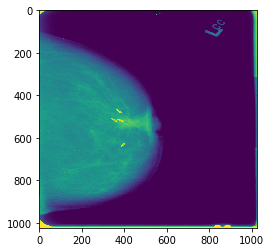

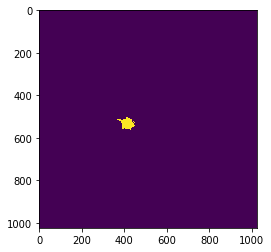

In [11]:
from matplotlib.pyplot import imread, imshow
import matplotlib.pyplot as plt

plt.imshow(image_stack[910])
plt.show()
plt.imshow(Y[910])
plt.show()

In [5]:
Y = np.array(Y)
Y = np.squeeze(Y)
m,l,h = image_stack.shape

print(image_stack.shape)
X = image_stack.reshape((m,l,h,1))
Y = Y.reshape((m,l*h,1))
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.6,random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test,Y_test,train_size=0.5,random_state=42)

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

# Y_train = Y_train.reshape((m,l*h,1))



(3100, 1024, 1024)
(1860, 1024, 1024, 1)
(1860, 1048576, 1)
(620, 1024, 1024, 1)
(620, 1048576, 1)
(620, 1024, 1024, 1)
(620, 1048576, 1)


In [17]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
Y_val = to_categorical(Y_val)

In [6]:
#Taken from https://stackoverflow.com/questions/45947351/how-to-use-tensorflow-metrics-in-keras

def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

In [7]:
#Taken from https://stackoverflow.com/questions/45947351/how-to-use-tensorflow-metrics-in-keras

@as_keras_metric
def mean_iou(y_true, y_pred, num_classes=2):
    return tf.metrics.mean_iou(y_true, y_pred, num_classes)


In [27]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=(l,h,1)))
model.add(Conv2D(128, kernel_size=(5, 5),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(100, 100)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(5, 5),
                 activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1048576))
model.add(Reshape((1048576, 1)))
model.add(Activation('sigmoid'))

model.compile(optimizer='Adam',
              loss='binary_crossentropy')
# model.summary()
# print(X_train.shape)
# print(Y_train.shape)
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [28]:
model.fit(X_train,Y_train,epochs=20, validation_data=(X_val, Y_val), batch_size=1,verbose=1, callbacks=[tensorboard])

Train on 60 samples, validate on 20 samples
Epoch 1/20
 7/60 [==>...........................] - ETA: 13:53 - loss: 0.4044

KeyboardInterrupt: 

In [8]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=(l,h,1)))
model.add(Conv2D(8, kernel_size=(5, 5),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(50, 50)))
model.add(Dropout(0.25))
model.add(Conv2D(4, kernel_size=(5, 5),
                 activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1048576))
model.add(Reshape((1048576, 1)))
model.add(Activation('sigmoid'))

model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=[mean_iou])
# model.summary()
# print(X_train.shape)
# print(Y_train.shape)

In [ ]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
filepath = 'conv_net_weights.{epoch:02d}-{val_mean_iou:.3f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_iou', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
model.fit(X_train,Y_train,epochs=5, validation_data=(X_val, Y_val), batch_size=16,verbose=1, callbacks=[tensorboard, checkpoint])

Train on 60 samples, validate on 20 samples
Epoch 1/5


In [103]:
# From https://github.com/zizhaozhang/unet-tensorflow-keras
'''
 * @author [Zizhao Zhang]
 * @email [zizhao@cise.ufl.edu]
 * @create date 2017-05-25 02:21:13
 * @modify date 2017-05-25 02:21:13
 * @desc [description]
'''
import tensorflow as tf
try:
    from tensorflow.contrib import keras as keras
    print ('load keras from tensorflow package')
except:
    print ('update your tensorflow')
from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import layers 

class UNet():
    def __init__(self):
        print ('build UNet ...')

    def get_crop_shape(self, target, refer):
        # width, the 3rd dimension
        cw = (target.get_shape()[2] - refer.get_shape()[2]).value
        assert (cw >= 0)
        if cw % 2 != 0:
            cw1, cw2 = int(cw/2), int(cw/2) + 1
        else:
            cw1, cw2 = int(cw/2), int(cw/2)
        # height, the 2nd dimension
        ch = (target.get_shape()[1] - refer.get_shape()[1]).value
        assert (ch >= 0)
        if ch % 2 != 0:
            ch1, ch2 = int(ch/2), int(ch/2) + 1
        else:
            ch1, ch2 = int(ch/2), int(ch/2)

        return (ch1, ch2), (cw1, cw2)

    def create_model(self, img_shape, num_class):

        concat_axis = 3
        inputs = layers.Input(shape = img_shape)

        conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_1')(inputs)
        conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
        pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
        conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
        conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
        pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
        conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
        pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
        conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
        pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

        conv5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
        conv5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

        up_conv5 = layers.UpSampling2D(size=(2, 2))(conv5)
        ch, cw = self.get_crop_shape(conv4, up_conv5)
        crop_conv4 = layers.Cropping2D(cropping=(ch,cw))(conv4)
        up6 = layers.concatenate([up_conv5, crop_conv4], axis=concat_axis)
        conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
        conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

        up_conv6 = layers.UpSampling2D(size=(2, 2))(conv6)
        ch, cw = self.get_crop_shape(conv3, up_conv6)
        crop_conv3 = layers.Cropping2D(cropping=(ch,cw))(conv3)
        up7 = layers.concatenate([up_conv6, crop_conv3], axis=concat_axis) 
        conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
        conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

        up_conv7 = layers.UpSampling2D(size=(2, 2))(conv7)
        ch, cw = self.get_crop_shape(conv2, up_conv7)
        crop_conv2 = layers.Cropping2D(cropping=(ch,cw))(conv2)
        up8 = layers.concatenate([up_conv7, crop_conv2], axis=concat_axis)
        conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
        conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

        up_conv8 = layers.UpSampling2D(size=(2, 2))(conv8)
        ch, cw = self.get_crop_shape(conv1, up_conv8)
        crop_conv1 = layers.Cropping2D(cropping=(ch,cw))(conv1)
        up9 = layers.concatenate([up_conv8, crop_conv1], axis=concat_axis)
        conv9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
        conv9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

        ch, cw = self.get_crop_shape(inputs, conv9)
        conv9 = layers.ZeroPadding2D(padding=((ch[0], ch[1]), (cw[0], cw[1])))(conv9)
        conv10 = layers.Conv2D(num_class, (1, 1))(conv9)

        model = models.Model(inputs=inputs, outputs=conv10)

        return model



load keras from tensorflow package


In [106]:
unet = UNet()
model = unet.create_model((l,h,1), 2)
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=[mean_iou])

build UNet ...


In [107]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
filepath = 'conv_net_weights.{epoch:02d}-{val_mean_iou:.3f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_iou', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
model.fit(X_train,Y_train,epochs=5, validation_data=(X_val, Y_val), batch_size=1,verbose=1, callbacks=[tensorboard, checkpoint])

ValueError: Error when checking target: expected conv2d_36 to have 4 dimensions, but got array with shape (195, 1048576, 2)

In [7]:
#General model seems to need an extremely large output!
model = Sequential([
    Dense(128, input_shape=(l*h,)),
    Activation('relu'),
    Dense(64),
    Activation('relu'),
    Dense(32),
    Activation('relu'),
    Dense(32),
    Activation('relu'),
    Dense(3),
    Activation('relu'),
])
model.compile(optimizer='Adam',
              loss='categorical_crossentropy')
model.fit(X_train,Y_train,epochs=20, validation_data=(X_val, Y_val), batch_size=32)

Train on 71 samples, validate on 24 samples
Epoch 1/20
71/71 [==============================] - 26s 366ms/step - loss: 16666.3377 - val_loss: 11683.5654
Epoch 2/20
71/71 [==============================] - 13s 185ms/step - loss: 7853.4531 - val_loss: 453.2060
Epoch 3/20
71/71 [==============================] - 11s 157ms/step - loss: 385.5853 - val_loss: 344.5707
Epoch 4/20
71/71 [==============================] - 8s 118ms/step - loss: 350.8421 - val_loss: 344.5707
Epoch 5/20
71/71 [==============================] - 10s 134ms/step - loss: 350.8421 - val_loss: 344.5707
Epoch 6/20
71/71 [==============================] - 13s 183ms/step - loss: 350.8421 - val_loss: 344.5707
Epoch 7/20
71/71 [==============================] - 10s 136ms/step - loss: 350.8421 - val_loss: 344.5707
Epoch 8/20
71/71 [==============================] - 9s 132ms/step - loss: 350.8421 - val_loss: 344.5707
Epoch 9/20
71/71 [==============================] - 10s 137ms/step - loss: 350.8421 - val_loss: 344.5707
Epoch 10

In [8]:
y_pred_val = model.predict(X_train)

In [9]:
print(y_pred_val)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [28]:
print(Y_val)

[[448. 480.  95.]
 [492. 473. 131.]
 [600. 514.  67.]
 [518. 191.  39.]
 [356. 945.  72.]
 [647. 503.  87.]
 [523. 482.  29.]
 [547. 520.  45.]
 [366. 620.  33.]
 [525. 425.  33.]
 [489. 480.  82.]
 [415. 460.  38.]
 [326. 607. 174.]
 [352. 624. 114.]
 [462. 406.  44.]
 [603. 538.  44.]
 [522. 553.  17.]
 [519. 362.  54.]
 [592. 670.  33.]
 [493. 125.  49.]
 [612. 297.  34.]
 [191. 549.  23.]
 [400. 484.  37.]
 [653. 477.  49.]]


In [ ]:
model2 = Sequential([
    Dense(1024, input_shape=(l*h,)),
    Activation('relu'),
    Dense(512),
    Activation('relu'),
    Dense(256),
    Activation('relu'),
    Dense(64),
    Activation('relu'),
    Dense(3),
    Activation('relu'),
])
model2.compile(optimizer='Adam',
              loss='mean_squared_error')
model2.fit(X_train,Y_train,epochs=20, validation_data=(X_val, Y_val), batch_size=32)

Train on 71 samples, validate on 24 samples
Epoch 1/20


In [18]:
model2 = Sequential([
    Dense(128, input_shape=(l*h,)),
    Activation('relu'),
    Dense(64),
    Activation('relu'),
    Dense(32),
    Activation('relu'),
    Dense(16),
    Activation('relu'),
    Dense(3),
    Activation('relu'),
])
model2.compile(optimizer='Adam',
              loss='mean_squared_error')
# print(X_train[0].shape)
model2.fit(,epochs=5, batch_size=32)

(1048576,)


ValueError: Error when checking target: expected activation_55 to have shape (3,) but got array with shape (1,)

In [9]:
image = Image.new('1', (1024, 1024)) #create new image, 10x10 pixels, 1 bit per pixel
print(Y_train[0])

[492. 434.  87.]


In [ ]:
draw = ImageDraw.Draw(image)
draw.ellipse((2, 2, 8, 8), outline ='white')
print list(image.getdata())